In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch as th
import random
import IPython.display as dsp
import soundfile as sf
from asteroid.metrics import get_metrics
import pandas as pd
import tqdm
import torchaudio as ta
import os

blue = '#1f77b4' # 蓝色
orange = '#ff7f0e' # 橙色
green = '#2ca02c' # 绿色
red = '#d62728' # 红色

import sys
sys.path.append('/data2/yqc/zzf/repo_zzf/speakerbeam/src')
from models.td_speakerbeam import TimeDomainSpeakerBeam

In [2]:
device = th.device('cuda:0')

In [3]:
modelpath = '../example/model.pth' # 预训练模型路径
model = TimeDomainSpeakerBeam.from_pretrained(modelpath) # 加载预训练模型
model = model.to(device)

In [5]:
    def sisnr(x, s, eps=1e-8):
        """
        Arguments:
        x: separated signal, N x S tensor
        s: reference signal, N x S tensor
        Return:
        sisnr: N tensor
        """

        def l2norm(mat, keepdim=False):
            return th.norm(mat, dim=-1, keepdim=keepdim)

        if x.shape != s.shape:
            raise RuntimeError(
                "Dimention mismatch when calculate si-snr, {} vs {}".format(
                    x.shape, s.shape))
        x_zm = x - th.mean(x, dim=-1, keepdim=True)
        s_zm = s - th.mean(s, dim=-1, keepdim=True)
        t = th.sum(
            x_zm * s_zm, dim=-1,
            keepdim=True) * s_zm / (l2norm(s_zm, keepdim=True)**2 + eps)
        return 20 * th.log10(eps + l2norm(t) / (l2norm(x_zm - t) + eps))

### baseline

#### Libri2Mix(8kmin) / test / mix_both

In [5]:

csv = '/data2/yqc/zzf/repo_zzf/speakerbeam/egs/libri2mix/data/wav8k/min/test/map_mixture2enrollment'

with open(csv, 'r') as f:
    lines = f.readlines()
    
mix_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/mix_both/'
tt_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/'

sisdri_list_librimix = []
for line in tqdm.tqdm(lines):
    
    line = line.strip()
    mix_file, aux_spk, aux_file = line.split(' ')
    
    mix_path = os.path.join(mix_base, mix_file+'.wav')
    aux_path = os.path.join(tt_base, aux_file+'.wav')
    if aux_spk == mix_file.split('_')[0]:
        gt_path = os.path.join(tt_base, 's1', mix_file+'.wav')
    elif aux_spk == mix_file.split('_')[1]:
        gt_path = os.path.join(tt_base, 's2', mix_file+'.wav')
    
    mix_wav, fs = ta.load(mix_path)
    aux_wav, fs = ta.load(aux_path)
    gt_wav, fs = ta.load(gt_path)
    
    mix_wav = mix_wav.squeeze().to(device)
    aux_wav = aux_wav.squeeze().to(device)
    gt_wav = gt_wav.squeeze().to(device)
    
    # 说话人抽取
    est_wav = model(mix_wav.unsqueeze(0), aux_wav.unsqueeze(0))[0][0].detach() # 推理
    
    minlen = min(len(mix_wav.squeeze()), len(est_wav.squeeze()), len(gt_wav))
    mix_wav = mix_wav[:minlen]
    gt_wav = gt_wav[:minlen]
    est_wav = est_wav[:minlen]
    
    rto_with_gt(given_wavs=[est_wav, mix_wav], gt_wav=gt_wav)
    rto_with_ref(given_wavs=[est_wav, mix_wav], gt_wav=gt_wav)
    
    sisdr_mix = sisnr(mix_wav, gt_wav)
    sisdr_sep = sisnr(est_wav, gt_wav)
    sisdr_i = sisdr_sep - sisdr_mix
    sisdri_list_librimix.append(sisdr_i.cpu().item())
    
    #break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [15:07<00:00,  6.61it/s]


In [38]:
for i in range(len(sisdri_list_librimix)):
    sisdri_list_librimix[i] = sisdri_list_librimix[i].item()

In [39]:
np.save('sisdri_list_librimix(mix-both)_baseline.npy', sisdri_list_librimix)

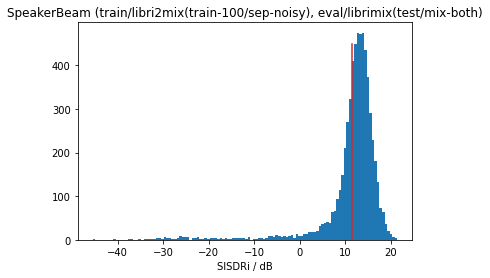

mean SISDRi = 11.43 dB


In [58]:
sisdri_mean = np.mean(sisdri_list_librimix)

mean_bar = 450
plt.figure()
plt.hist(sisdri_list_librimix, bins=len(sisdri_list_librimix)//50)
plt.plot(sisdri_mean * np.ones(mean_bar), np.arange(mean_bar), red)
plt.title('SpeakerBeam (train/libri2mix(train-100/sep-noisy), eval/librimix(test/mix-both)')
plt.xlabel('SISDRi / dB')
plt.show()

print('mean SISDRi = {:.2f} dB'.format(sisdri_mean))

### RunTime Optimization

#### Libri2Mix(8kmin) / test / mix_both

##### RTO with gt

In [13]:
def rto_with_gt(given_wavs, gt_wav):
    
    est_wav, mix_wav = given_wavs
    
    sisnr_best = sisnr(mix_wav, gt_wav)
    w_best = 1
    for i in range(0, 10): # 0 1 2 3 4 5 6 7 8 9
        w = i/10
        rto_wav = w * est_wav + (1-w) * mix_wav
        sisnr_rto = sisnr(rto_wav, gt_wav)
        if sisnr_best < sisnr_rto:
            sisnr_best = sisnr_rto
            w_best = w
    
    return sisnr_best, w_best

csv = '/data2/yqc/zzf/repo_zzf/speakerbeam/egs/libri2mix/data/wav8k/min/test/map_mixture2enrollment'

with open(csv, 'r') as f:
    lines = f.readlines()
    
mix_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/mix_both/'
tt_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/'

sisdri_list_librimix = []
for line in tqdm.tqdm(lines):
    
    line = line.strip()
    mix_file, aux_spk, aux_file = line.split(' ')
    
    mix_path = os.path.join(mix_base, mix_file+'.wav')
    aux_path = os.path.join(tt_base, aux_file+'.wav')
    if aux_spk == mix_file.split('_')[0]:
        gt_path = os.path.join(tt_base, 's1', mix_file+'.wav')
    elif aux_spk == mix_file.split('_')[1]:
        gt_path = os.path.join(tt_base, 's2', mix_file+'.wav')
    
    mix_wav, fs = ta.load(mix_path)
    aux_wav, fs = ta.load(aux_path)
    gt_wav, fs = ta.load(gt_path)
    
    mix_wav = mix_wav.squeeze().to(device)
    aux_wav = aux_wav.squeeze().to(device)
    gt_wav = gt_wav.squeeze().to(device)
    
    # 说话人抽取
    est_wav = model(mix_wav.unsqueeze(0), aux_wav.unsqueeze(0))[0][0].detach() # 推理
    
    minlen = min(len(mix_wav.squeeze()), len(est_wav.squeeze()), len(gt_wav))
    mix_wav = mix_wav[:minlen]
    gt_wav = gt_wav[:minlen]
    est_wav = est_wav[:minlen]
    
    sisdr_best, w_best = rto_with_gt(given_wavs=[est_wav, mix_wav], gt_wav=gt_wav)
    sisdr_best.cpu().item()
    
    sisdr_mix = sisnr(mix_wav, gt_wav).cpu().item()
    sisdr_sep = sisnr(est_wav, gt_wav).cpu().item()
    sisdr_i = sisdr_sep - sisdr_mix
    sisdri_list_librimix.append(sisdr_i)
    
    if sisdr_best > sisdr_sep:
        print(sisdr_best, sisdr_sep)

  0%|                                                                                                             | 1/6000 [00:00<16:18,  6.13it/s]

tensor(12.7138, device='cuda:0') 12.713770866394043


  0%|                                                                                                             | 5/6000 [00:00<18:52,  5.29it/s]

tensor(13.5109, device='cuda:0') 13.510740280151367


  0%|▏                                                                                                            | 8/6000 [00:01<16:37,  6.00it/s]

tensor(8.5174, device='cuda:0') 8.517367362976074


  0%|▏                                                                                                           | 10/6000 [00:01<18:36,  5.37it/s]

tensor(13.1379, device='cuda:0') 13.13789176940918
tensor(14.4639, device='cuda:0') 14.463830947875977


  0%|▏                                                                                                           | 13/6000 [00:02<12:56,  7.71it/s]

tensor(17.9536, device='cuda:0') 17.95363998413086
tensor(14.8013, device='cuda:0') 14.801290512084961


  0%|▎                                                                                                           | 15/6000 [00:02<13:22,  7.46it/s]

tensor(13.4032, device='cuda:0') 13.403204917907715
tensor(10.4891, device='cuda:0') 10.489141464233398


  0%|▎                                                                                                           | 20/6000 [00:03<13:32,  7.36it/s]

tensor(15.0881, device='cuda:0') 15.088083267211914
tensor(9.5746, device='cuda:0') 9.574604988098145


  0%|▍                                                                                                           | 22/6000 [00:03<12:59,  7.67it/s]

tensor(10.4500, device='cuda:0') 10.450021743774414
tensor(11.7105, device='cuda:0') 11.710493087768555


  0%|▍                                                                                                           | 24/6000 [00:03<15:20,  6.49it/s]

tensor(9.7878, device='cuda:0') 9.78776741027832


  0%|▌                                                                                                           | 29/6000 [00:04<20:59,  4.74it/s]

tensor(14.4808, device='cuda:0') 14.480802536010742


  0%|▌                                                                                                           | 30/6000 [00:05<22:30,  4.42it/s]

tensor(8.6961, device='cuda:0') 8.69607162475586


  1%|▌                                                                                                           | 33/6000 [00:05<21:58,  4.52it/s]

tensor(12.1773, device='cuda:0') 12.177295684814453


  1%|▋                                                                                                           | 35/6000 [00:06<21:54,  4.54it/s]

tensor(15.5673, device='cuda:0') 15.56728744506836


  1%|▋                                                                                                           | 37/6000 [00:06<19:46,  5.03it/s]

tensor(11.3174, device='cuda:0') 11.317338943481445


  1%|▋                                                                                                           | 38/6000 [00:06<18:07,  5.48it/s]

tensor(10.6150, device='cuda:0') 10.61502456665039
tensor(8.4536, device='cuda:0') 8.453638076782227


  1%|▋                                                                                                           | 41/6000 [00:07<15:04,  6.59it/s]

tensor(11.4267, device='cuda:0') 11.426630020141602
tensor(2.3520, device='cuda:0') -13.330442428588867


  1%|▊                                                                                                           | 45/6000 [00:07<12:43,  7.80it/s]

tensor(13.3679, device='cuda:0') 13.367881774902344
tensor(9.2033, device='cuda:0') 9.20327377319336
tensor(6.9982, device='cuda:0') 6.998117446899414


  1%|▉                                                                                                           | 50/6000 [00:08<12:37,  7.86it/s]

tensor(5.8250, device='cuda:0') 5.824994087219238
tensor(8.7722, device='cuda:0') 8.772029876708984


  1%|▉                                                                                                           | 50/6000 [00:08<17:30,  5.67it/s]


KeyboardInterrupt: 

In [67]:
sisnr_best

tensor(12.2696, device='cuda:0')

In [68]:
sisdr_sep

tensor(12.2696, device='cuda:0')

In [65]:
np.save('sisdri_list_librimix(mix-both)_rto-gt.npy', sisdri_list_librimix)

##### RTO with aux

In [ ]:
def rto_with_aux(given_wavs, aux_wav):
    
    est_wav, mix_wav = given_wavs
    
    sisnr_best = sisnr(mix_wav, gt_wav)
    w_best = 1
    for i in range(0, 10): # 0 1 2 3 4 5 6 7 8 9
        w = i/10
        rto_wav = w * est_wav + (1-w) * mix_wav
        sisnr_rto = sisnr(rto_wav, gt_wav)
        if sisnr_best < sisnr_rto:
            sisnr_best = sisnr_rto
            w_best = w
    
    return sisnr_best, w_best

csv = '/data2/yqc/zzf/repo_zzf/speakerbeam/egs/libri2mix/data/wav8k/min/test/map_mixture2enrollment'

with open(csv, 'r') as f:
    lines = f.readlines()
    
mix_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/mix_both/'
tt_base = '/data2/yqc/zzf/dataset_zzf/librimix/Libri2Mix/wav8k/min/test/'

sisdri_list_librimix = []
for line in tqdm.tqdm(lines):
    
    line = line.strip()
    mix_file, aux_spk, aux_file = line.split(' ')
    
    mix_path = os.path.join(mix_base, mix_file+'.wav')
    aux_path = os.path.join(tt_base, aux_file+'.wav')
    if aux_spk == mix_file.split('_')[0]:
        gt_path = os.path.join(tt_base, 's1', mix_file+'.wav')
    elif aux_spk == mix_file.split('_')[1]:
        gt_path = os.path.join(tt_base, 's2', mix_file+'.wav')
    
    mix_wav, fs = ta.load(mix_path)
    aux_wav, fs = ta.load(aux_path)
    gt_wav, fs = ta.load(gt_path)
    
    mix_wav = mix_wav.squeeze().to(device)
    aux_wav = aux_wav.squeeze().to(device)
    gt_wav = gt_wav.squeeze().to(device)
    
    # 说话人抽取
    est_wav = model(mix_wav.unsqueeze(0), aux_wav.unsqueeze(0))[0][0].detach() # 推理
    
    minlen = min(len(mix_wav.squeeze()), len(est_wav.squeeze()), len(gt_wav))
    mix_wav = mix_wav[:minlen]
    gt_wav = gt_wav[:minlen]
    est_wav = est_wav[:minlen]
    
    sisdr_mix = sisnr(mix_wav, gt_wav)
    sisdr_sep = sisnr(est_wav, gt_wav)
    sisdr_i = sisdr_sep - sisdr_mix
    sisdri_list_librimix.append(sisdr_i.cpu().numpy())
                       
    rto_wav, w_rto = rto_with_aux(given_wavs=[est_wav, mix_wav], aux_wav=aux_wav)
    sisnr_rto  = sisnr(rto_wav, gt_wav)
    sisdr_i_rto = sisnr_rto - sisdr_mix
    sisdri_list_librimix_rto.append(sisdr_i_rto.cpu().item())
    
    break